### $$ Redacteur :\;\;\; Jeff\; Lwear \;DUVERSEAU$$

# Project Title

### $$ "Explorer \;le\; Box\; Office: Strat√©gie\; de\; contenu\; pour\; un\; studio\; naissant" $$

## Overview

Ce projet vise √† accompagner une entreprise dans le lancement de son studio de production cin√©matographique. Sans exp√©rience dans le domaine, elle souhaite s‚Äôinspirer des succ√®s de Netflix, Amazon ou Disney pour produire des films originaux.

√Ä partir de donn√©es issues de plusieurs sources (IMDb, Box Office Mojo, etc.), l‚Äôobjectif est d‚Äôidentifier les caract√©ristiques des films les plus performants en termes de popularit√© et de r√©ception critique, afin de fournir des recommandations claires sur les types de films √† privil√©gier.

## Business Understanding

Le projet vise √† d√©gager les leviers cl√©s qui conditionnent la r√©ussite d‚Äôun film au box-office. Il s‚Äôagit d‚Äôidentifier, √† partir de donn√©es historiques, les √©l√©ments qui influencent le plus la performance commerciale ou la popularit√© d‚Äôun film, tels que le genre, le budget, la dur√©e ou encore les avis critiques. L‚Äôenjeu est de fournir des rep√®res fiables aux acteurs du secteur pour orienter leurs choix de production et d‚Äôinvestissement. Pour cela, il est essentiel de formuler d√®s le d√©part des questions cibl√©es, √† fort impact d√©cisionnel : Quels profils de films sont les plus rentables ? Quels indicateurs permettent d‚Äôanticiper un succ√®s ? Cette phase permet de cadrer le besoin m√©tier en probl√©matique analytique claire.

## Library Importation

In [1]:
import itertools
import numpy as np
import pandas as pd
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
from IPython.core.display import HTML

# CSS √† appliquer
css = """
<style scoped>
.dataframe tbody tr th:only-of-type {
    vertical-align: middle;
}
.dataframe tbody tr th {
    vertical-align: top;
}
.dataframe thead th {
    text-align: right;
}
</style>
"""

# Afficher le CSS dans le notebook
display(HTML(css))

## Data Importation

In [3]:
# Create connections
conn = sqlite3.connect('im.db')
cursor = conn.cursor()

df1 = pd.read_csv('tmdb.movies.csv')

df2 = pd.read_csv('bom.movie_gross.csv')

df3 = pd.read_csv('tn.movie_budgets.csv')

df4 = pd.read_csv('rt.reviews.tsv', sep='\t', encoding='latin1')

df5 = pd.read_csv('rt.movie_info.tsv', sep='\t')

## Data Understanding

Ce projet repose sur un ensemble de donn√©es provenant de multiples sources aux formats vari√©s : certains fichiers sont plats (CSV, TSV), d'autres structur√©s dans une base relationnelle. Cette h√©t√©rog√©n√©it√© implique une phase initiale d‚Äôinspection rigoureuse pour examiner la composition des jeux de donn√©es, √©valuer leur qualit√©, d√©tecter d‚Äô√©ventuelles anomalies ou doublons, et rep√©rer les variables cl√©s. Il est √©galement essentiel de clarifier comment ces diff√©rentes sources s‚Äôarticulent entre elles, tant sur le plan logique que sur les correspondances entre champs. Cette compr√©hension globale conditionne la pertinence de la pr√©paration des donn√©es et la validit√© des analyses qui en d√©couleront.

In [4]:
# Affichons la liste des tables pr√©sentes dans la base relationnelle
table_name = """SELECT name AS 'Table Names' 
    FROM sqlite_master 
    WHERE type='table';"""

pd.read_sql(table_name, conn)

Table Names
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers

## $$ 1 - La \;base\; de\; donn√©es\; IMBD $$

Le sch√©ma relationnel de la base permet d‚Äôavoir une vision globale de sa structure, en mettant en √©vidence les diff√©rentes entit√©s ainsi que les attributs associ√©s √† chacune. En analysant cette repr√©sentation, on peut identifier la table centrale autour de laquelle s‚Äôarticulent les autres. Il s‚Äôagit ici de la table $movie\_basics$, qui joue un r√¥le cl√© dans l‚Äôorganisation des donn√©es.

Approfondissons maintenant l‚Äôanalyse de cette table afin de mieux comprendre sa composition et le type d‚Äôinformations qu‚Äôelle contient.



In [5]:
# Exploration de la table movie_basics
movie_basics = """
           SELECT *
        FROM movie_basics
    """
# Stockage de la table dans un DataFrame
movie_basics_df = pd.read_sql(movie_basics, conn) 
pd.read_sql(movie_basics, conn)

movie_id                                primary_title  \
0       tt0063540                                    Sunghursh   
1       tt0066787              One Day Before the Rainy Season   
2       tt0069049                   The Other Side of the Wind   
3       tt0069204                              Sabse Bada Sukh   
4       tt0100275                     The Wandering Soap Opera   
...           ...                                          ...   
146139  tt9916538                          Kuambil Lagi Hatiku   
146140  tt9916622  Rodolpho Te√≥philo - O Legado de um Pioneiro   
146141  tt9916706                              Dankyavar Danka   
146142  tt9916730                                       6 Gunn   
146143  tt9916754               Chico Albuquerque - Revela√ß√µes   

                                     original_title  start_year  \
0                                         Sunghursh        2013   
1                                   Ashad Ka Ek Din        2019   
2                        The Other Side of the Wind        2018   
3                                   Sabse Bada Sukh        2018   
4                             La Telenovela Errante        2017   
...                                             ...         ...   
146139                          Kuambil Lagi Hatiku        2019   
146140  Rodolpho Te√≥philo - O Legado de um Pioneiro        2015   
146141                              Dankyavar Danka        2013   
146142                                       6 Gunn        2017   
146143               Chico Albuquerque - Revela√ß√µes        2013   

        runtime_minutes                genres  
0                 175.0    Action,Crime,Drama  
1                 114.0       Biography,Drama  
2                 122.0                 Drama  
3                   NaN          Comedy,Drama  
4                  80.0  Comedy,Drama,Fantasy  
...                 ...                   ...  
146139            123.0                 Drama  
146140              NaN           Documentary  
146141              NaN                Comedy  
146142            116.0                  None  
146143              NaN           Documentary  

[146144 rows x 6 columns]

#### Commentaire
La table movie_basics contient 146 144 enregistrements r√©partis sur 6 colonnes. Chaque film est identifi√© par une cl√© primaire movie_id, suppos√©e unique pour garantir l‚Äôunicit√© des lignes.
Cette table fournit des informations essentielles sur les films, notamment leurs titres (original et principal), leur ann√©e de sortie, leur dur√©e et surtout leur genre.

La colonne genres joue un r√¥le central dans notre analyse, car elle permet de cat√©goriser les films et de r√©pondre √† l'une des questions cl√©s du projet :

"Quels types de films rencontrent le plus de succ√®s aupr√®s du public et des critiques ?"

C‚Äôest donc sur cette colonne que nous concentrerons une partie importante de notre √©tude exploratoire.

V√©rifions maintenant l‚Äôunicit√© de cette colonne afin de s‚Äôassurer qu‚Äôaucun doublon n‚Äôest pr√©sent.

In [6]:
# R√©perer les doublons dans la table 
duplicate_value = """SELECT movie_id, COUNT(*) AS doublons
FROM movie_basics
GROUP BY movie_id
HAVING COUNT(*) > 1
ORDER BY doublons DESC;"""

pd.read_sql(duplicate_value, conn)

Empty DataFrame
Columns: [movie_id, doublons]
Index: []

#### Commentaire
Les 146 144 lignes de la table movie_basics correspondent chacune √† un film unique. Aucune duplication n‚Äôa √©t√© d√©tect√©e, ce qui confirme l‚Äôint√©grit√© de la cl√© primaire movie_id.

In [7]:
# Pourcentage de valeurs manquantes dans la colonne genres.
missing_percentage = movie_basics_df[['genres']].isnull().mean() * 100
print(missing_percentage)

genres    3.70046
dtype: float64


In [8]:
# Exploration de la table movie_akas
movie_akas = """
           SELECT *
        FROM movie_akas
    """
# Stockage de la table dans un DataFrame
movie_akas_df = pd.read_sql(movie_akas, conn) 
pd.read_sql(movie_akas, conn)

movie_id  ordering                                    title region  \
0       tt0369610        10                            –î–∂—É—Ä–∞—Å–∏–∫ —Å–≤—è—Ç     BG   
1       tt0369610        11                        Jurashikku warudo     JP   
2       tt0369610        12  Jurassic World: O Mundo dos Dinossauros     BR   
3       tt0369610        13                  O Mundo dos Dinossauros     BR   
4       tt0369610        14                           Jurassic World     FR   
...           ...       ...                                      ...    ...   
331698  tt9827784         2                       Sayonara kuchibiru   None   
331699  tt9827784         3                            Farewell Song    XWW   
331700  tt9880178         1                              La atenci√≥n   None   
331701  tt9880178         2                              La atenci√≥n     ES   
331702  tt9880178         3                            The Attention    XWW   

       language        types   attributes  is_original_title  
0            bg         None         None                0.0  
1          None  imdbDisplay         None                0.0  
2          None  imdbDisplay         None                0.0  
3          None         None  short title                0.0  
4          None  imdbDisplay         None                0.0  
...         ...          ...          ...                ...  
331698     None     original         None                1.0  
331699       en  imdbDisplay         None                0.0  
331700     None     original         None                1.0  
331701     None         None         None                0.0  
331702       en  imdbDisplay         None                0.0  

[331703 rows x 8 columns]

#### Commentaire
La table movie_akas contient les titres alternatifs des films selon les r√©gions, langues ou types de diffusion. Chaque enregistrement est li√© √† un movie_id et indique si le titre est l‚Äôoriginal (is_original_title = 1).

Elle permet d‚Äôidentifier les diff√©rentes appellations d‚Äôun m√™me film √† l‚Äôinternational. Bien qu‚Äôelle ne soit pas centrale pour notre analyse, elle peut servir √† enrichir le contexte autour des titres.

In [9]:
# Exploration de la table movie_ratings
movie_ratings = """
           SELECT *
        FROM movie_ratings
    """
# Stockage de la table dans un DataFrame
movie_ratings_df = pd.read_sql(movie_ratings, conn) 
pd.read_sql(movie_ratings, conn)

movie_id  averagerating  numvotes
0      tt10356526            8.3        31
1      tt10384606            8.9       559
2       tt1042974            6.4        20
3       tt1043726            4.2     50352
4       tt1060240            6.5        21
...           ...            ...       ...
73851   tt9805820            8.1        25
73852   tt9844256            7.5        24
73853   tt9851050            4.7        14
73854   tt9886934            7.0         5
73855   tt9894098            6.3       128

[73856 rows x 3 columns]

#### Commentaire

La table movie_ratings fournit des informations sur la popularit√© et la r√©ception des films, √† travers deux colonnes cl√©s :

averagerating : la note moyenne attribu√©e par les utilisateurs,

numvotes : le nombre de votes ayant contribu√© √† cette note.

Ces deux variables sont essentielles pour √©valuer l‚Äôappr√©ciation du public.
Combin√©es √† la colonne genres de la table movie_basics, elles constituent la base principale de notre analyse, qui vise √† identifier les types de films les mieux not√©s et les plus populaires.

In [10]:
# R√©perer les doublons dans la table 
duplicate_value = """SELECT movie_id, COUNT(*) AS doublons
FROM movie_ratings
GROUP BY movie_id
HAVING COUNT(*) > 1
ORDER BY doublons DESC;"""

pd.read_sql(duplicate_value, conn)

Empty DataFrame
Columns: [movie_id, doublons]
Index: []

In [11]:
# Pourcentage de valeurs manquantes dans les colonnes averagerating, numvotes.
missing_percentage = movie_ratings_df[['averagerating', 'numvotes']].isnull().mean() * 100
print(missing_percentage)

averagerating    0.0
numvotes         0.0
dtype: float64


Les 73856 lignes de la table movie_ratings correspondent chacune √† un film unique. Aucune duplication n‚Äôa √©t√© d√©tect√©e, ce qui confirme l‚Äôint√©grit√© de la cl√© primaire movie_id.

In [12]:
# Exploration de la table directors
directors = """
           SELECT *
        FROM directors
    """
# Stockage de la table dans un DataFrame
directors_df = pd.read_sql(directors, conn) 
pd.read_sql(directors, conn)

movie_id   person_id
0       tt0285252   nm0899854
1       tt0462036   nm1940585
2       tt0835418   nm0151540
3       tt0835418   nm0151540
4       tt0878654   nm0089502
...           ...         ...
291169  tt8999974  nm10122357
291170  tt9001390   nm6711477
291171  tt9001494  nm10123242
291172  tt9001494  nm10123248
291173  tt9004986   nm4993825

[291174 rows x 2 columns]

In [13]:
# Exploration de la table principals
principals = """
           SELECT *
        FROM principals
    """
# Stockage de la table dans un DataFrame
principals_df = pd.read_sql(principals, conn) 
pd.read_sql(principals, conn)

movie_id  ordering   person_id  category       job  \
0        tt0111414         1   nm0246005     actor      None   
1        tt0111414         2   nm0398271  director      None   
2        tt0111414         3   nm3739909  producer  producer   
3        tt0323808        10   nm0059247    editor      None   
4        tt0323808         1   nm3579312   actress      None   
...            ...       ...         ...       ...       ...   
1028181  tt9692684         1   nm0186469     actor      None   
1028182  tt9692684         2   nm4929530      self      None   
1028183  tt9692684         3  nm10441594  director      None   
1028184  tt9692684         4   nm6009913    writer    writer   
1028185  tt9692684         5  nm10441595  producer  producer   

                   characters  
0                 ["The Man"]  
1                        None  
2                        None  
3                        None  
4            ["Beth Boothby"]  
...                       ...  
1028181  ["Ebenezer Scrooge"]  
1028182   ["Herself","Regan"]  
1028183                  None  
1028184                  None  
1028185                  None  

[1028186 rows x 6 columns]

In [13]:
# Exploration de la table persons
persons = """
           SELECT *
        FROM persons
    """
# Stockage de la table dans un DataFrame
persons_df = pd.read_sql(persons, conn) 
pd.read_sql(persons, conn)

person_id         primary_name  birth_year  death_year  \
0       nm0061671    Mary Ellen Bauder         NaN         NaN   
1       nm0061865         Joseph Bauer         NaN         NaN   
2       nm0062070           Bruce Baum         NaN         NaN   
3       nm0062195         Axel Baumann         NaN         NaN   
4       nm0062798          Pete Baxter         NaN         NaN   
...           ...                  ...         ...         ...   
606643  nm9990381         Susan Grobes         NaN         NaN   
606644  nm9990690          Joo Yeon So         NaN         NaN   
606645  nm9991320       Madeline Smith         NaN         NaN   
606646  nm9991786  Michelle Modigliani         NaN         NaN   
606647  nm9993380       Pegasus Envoy√©         NaN         NaN   

                                      primary_profession  
0              miscellaneous,production_manager,producer  
1             composer,music_department,sound_department  
2                             miscellaneous,actor,writer  
3       camera_department,cinematographer,art_department  
4       production_designer,art_department,set_decorator  
...                                                  ...  
606643                                           actress  
606644                                           actress  
606645                                           actress  
606646                                          producer  
606647                             director,actor,writer  

[606648 rows x 5 columns]

### Commentaire
Les tables directors, writers, persons et principals fournissent des informations pr√©cieuses sur les personnes impliqu√©es dans les films, notamment les acteurs, r√©alisateurs et sc√©naristes. Certaines colonnes indiquent √©galement leur date de naissance et leur date de d√©c√®s.

Cependant, ces deux derni√®res colonnes comportent un grand nombre de valeurs manquantes, ce qui limite fortement l‚Äôexploitation fiable de ces donn√©es. Bien que ces tables pourraient permettre d‚Äôanalyser, par exemple, les r√©alisateurs ou acteurs les plus associ√©s au succ√®s de certains genres, l‚Äôabsence d‚Äôinformations compl√®tes sur leur statut (vivant ou non) emp√™che d‚Äôint√©grer ces donn√©es de mani√®re coh√©rente dans notre √©tude.

Ainsi, pour garantir la robustesse de l‚Äôanalyse, ces tables seront n√©glig√©es dans la suite du projet.

## $$ 1 - Exploration \;des\; fichiers\; csv\; et\; tsv $$

In [14]:
df1.head()

Unnamed: 0            genre_ids     id original_language  \
0           0      [12, 14, 10751]  12444                en   
1           1  [14, 12, 16, 10751]  10191                en   
2           2        [12, 28, 878]  10138                en   
3           3      [16, 35, 10751]    862                en   
4           4        [28, 878, 12]  27205                en   

                                 original_title  popularity release_date  \
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      How to Train Your Dragon      28.734   2010-03-26   
2                                    Iron Man 2      28.515   2010-05-07   
3                                     Toy Story      28.005   1995-11-22   
4                                     Inception      27.920   2010-07-16   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
1                      How to Train Your Dragon           7.7        7610  
2                                    Iron Man 2           6.8       12368  
3                                     Toy Story           7.9       10174  
4                                     Inception           8.3       22186

In [15]:
df2.head()

title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010

In [16]:
df3.head()

id  release_date                                        movie  \
0   1  Dec 18, 2009                                       Avatar   
1   2  May 20, 2011  Pirates of the Caribbean: On Stranger Tides   
2   3   Jun 7, 2019                                 Dark Phoenix   
3   4   May 1, 2015                      Avengers: Age of Ultron   
4   5  Dec 15, 2017            Star Wars Ep. VIII: The Last Jedi   

  production_budget domestic_gross worldwide_gross  
0      $425,000,000   $760,507,625  $2,776,345,279  
1      $410,600,000   $241,063,875  $1,045,663,875  
2      $350,000,000    $42,762,350    $149,762,350  
3      $330,600,000   $459,005,868  $1,403,013,963  
4      $317,000,000   $620,181,382  $1,316,721,747

In [17]:
df4.head()

id                                             review rating   fresh  \
0   3  A distinctly gallows take on contemporary fina...    3/5   fresh   
1   3  It's an allegory in search of a meaning that n...    NaN  rotten   
2   3  ... life lived in a bubble in financial dealin...    NaN   fresh   
3   3  Continuing along a line introduced in last yea...    NaN   fresh   
4   3             ... a perverse twist on neorealism...     NaN   fresh   

           critic  top_critic         publisher               date  
0      PJ Nabarro           0   Patrick Nabarro  November 10, 2018  
1  Annalee Newitz           0           io9.com       May 23, 2018  
2    Sean Axmaker           0  Stream on Demand    January 4, 2018  
3   Daniel Kasman           0              MUBI  November 16, 2017  
4             NaN           0      Cinema Scope   October 12, 2017

In [18]:
df5.head()

id                                           synopsis rating  \
0   1  This gritty, fast-paced, and innovative police...      R   
1   3  New York City, not-too-distant-future: Eric Pa...      R   
2   5  Illeana Douglas delivers a superb performance ...      R   
3   6  Michael Douglas runs afoul of a treacherous su...      R   
4   7                                                NaN     NR   

                                 genre          director  \
0  Action and Adventure|Classics|Drama  William Friedkin   
1    Drama|Science Fiction and Fantasy  David Cronenberg   
2    Drama|Musical and Performing Arts    Allison Anders   
3           Drama|Mystery and Suspense    Barry Levinson   
4                        Drama|Romance    Rodney Bennett   

                            writer  theater_date      dvd_date currency  \
0                   Ernest Tidyman   Oct 9, 1971  Sep 25, 2001      NaN   
1     David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   
2                   Allison Anders  Sep 13, 1996  Apr 18, 2000      NaN   
3  Paul Attanasio|Michael Crichton   Dec 9, 1994  Aug 27, 1997      NaN   
4                     Giles Cooper           NaN           NaN      NaN   

  box_office      runtime             studio  
0        NaN  104 minutes                NaN  
1    600,000  108 minutes  Entertainment One  
2        NaN  116 minutes                NaN  
3        NaN  128 minutes                NaN  
4        NaN  200 minutes                NaN

### Commentaire
L‚Äôexamen des fichiers CSV et TSV r√©v√®le une absence de compl√©tude et de coh√©rence avec la base de donn√©es SQLite. √âtant issus de sources diff√©rentes, ces fichiers ne partagent pas de structure ni de cl√©s communes, ce qui rend quasiment impossible la cr√©ation de liens fiables pour une exploitation conjointe.

L‚Äôanalyse du fichier tmdb.movies.csv montre qu‚Äôil contient des informations int√©ressantes telles que le titre et le nombre de votes, mais la colonne genre_ids fait r√©f√©rence √† une table externe non disponible. Or, le genre √©tant une variable cl√© de notre analyse, ce fichier ne peut pas √™tre utilis√©.

Le fichier bom.movie_gross.csv fournit des donn√©es sur les recettes et le titre, mais aucune information sur les genres. De m√™me, tn.movie_budgets.csv propose des informations √©conomiques, mais sans lien avec les genres.

Quant au fichier rt.movie_info.tsv, bien qu‚Äôil inclue des informations int√©ressantes sur les genres et la dur√©e des films, il ne fournit aucune donn√©e sur l‚Äôappr√©ciation du public, un autre axe central de notre √©tude.

Par cons√©quent, les fichiers CSV et TSV ne sont pas exploitables dans le cadre de notre analyse. Celle-ci se concentrera exclusivement sur la base de donn√©es SQLite, qui reste la seule source compl√®te et coh√©rente pour r√©pondre √† notre probl√©matique.

## Data Preparation

Les variables : genres, averagerating ou numvotes sont essentielles pour r√©pondre √† notre probl√©matique, qui consiste notamment √† identifier les types de films les plus appr√©ci√©s ou les plus consomm√©s par le public. De ce fait, nous allons creer une vue sur la base de donn√©es en etrayant uniquement les colonnes les plus pertinentes pour notre analyse et supprimant les enregistrememts ayant des valeurs manquantes essentielles (genres, averagerating ou numvotes).

Proc√©dons √† une jointure entre movie_basics, movie_ratings , movie_akas et directors pour enrichir les donn√©es

In [19]:
Jointure_query = """ CREATE VIEW IF NOT EXISTS imbd_final AS
SELECT
    mb.movie_id,
    mb.primary_title,
    mb.original_title,
    mb.start_year,
    mb.runtime_minutes,
    mb.genres,
    mr.averagerating,
    mr.numvotes,
    d.person_id,
    GROUP_CONCAT(DISTINCT ma.title) AS alt_titles
FROM movie_basics AS mb
LEFT JOIN movie_ratings AS mr ON mb.movie_id = mr.movie_id
LEFT JOIN directors AS d ON mb.movie_id = d.movie_id
LEFT JOIN movie_akas AS ma ON mb.movie_id = ma.movie_id AND ma.is_original_title = 1
WHERE mb.genres IS NOT NULL
    AND mr.averagerating IS NOT NULL
    AND mr.numvotes IS NOT NULL
GROUP BY mb.movie_id
"""

cursor.execute(Jointure_query)

In [20]:
# Exploration de la table jointure imbd_final
imbd_final = """
           SELECT *
        FROM imbd_final
    """
# Stockage de la table dans un DataFrame
imbd_final_df = pd.read_sql(imbd_final, conn) 
pd.read_sql(imbd_final, conn)

movie_id                    primary_title              original_title  \
0      tt0063540                        Sunghursh                   Sunghursh   
1      tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2      tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3      tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4      tt0100275         The Wandering Soap Opera       La Telenovela Errante   
...          ...                              ...                         ...   
73047  tt9913056                     Swarm Season                Swarm Season   
73048  tt9913084                 Diabolik sono io            Diabolik sono io   
73049  tt9914286                Sokagin √áocuklari           Sokagin √áocuklari   
73050  tt9914642                        Albatross                   Albatross   
73051  tt9916160                       Dr√∏mmeland                  Dr√∏mmeland   

       start_year  runtime_minutes                genres  averagerating  \
0            2013            175.0    Action,Crime,Drama            7.0   
1            2019            114.0       Biography,Drama            7.2   
2            2018            122.0                 Drama            6.9   
3            2018              NaN          Comedy,Drama            6.1   
4            2017             80.0  Comedy,Drama,Fantasy            6.5   
...           ...              ...                   ...            ...   
73047        2019             86.0           Documentary            6.2   
73048        2019             75.0           Documentary            6.2   
73049        2019             98.0          Drama,Family            8.7   
73050        2017              NaN           Documentary            8.5   
73051        2019             72.0           Documentary            6.5   

       numvotes  person_id                  alt_titles  
0            77  nm0712540                   Sunghursh  
1            43  nm0002411             Ashad Ka Ek Din  
2          4517  nm0000080  The Other Side of the Wind  
3            13  nm0611531             Sabse Bada Sukh  
4           119  nm0749914       La Telenovela Errante  
...         ...        ...                         ...  
73047         5  nm1502645                        None  
73048         6  nm0812850                        None  
73049       136  nm4394529                        None  
73050         8  nm5300859                        None  
73051        11  nm5684093                        None  

[73052 rows x 10 columns]

#### Commentaire
La table imbd_final, issue de la jointure des diff√©rentes sources, constitue notre jeu de donn√©es principal pour l‚Äôanalyse.
Elle contient 73 052 enregistrements r√©partis sur 10 colonnes, regroupant les informations essentielles sur les films, leurs genres, leur popularit√© (notes et votes).

## Analysis and Visualizations

### Orientation analytique

Pour r√©pondre √† notre objectif, comprendre ce qui fait le succ√®s d‚Äôun film, un premier angle d‚Äôattaque consiste √† s‚Äôint√©resser aux ≈ìuvres ayant obtenu les meilleures √©valuations du public. En effet, les films les mieux not√©s traduisent g√©n√©ralement une forte satisfaction des spectateurs.

Explorons donc les 150 films ayant obtenu les scores moyens les plus √©lev√©s, afin de rep√©rer les tendances qui pourraient orienter la production future.

In [21]:
best_movies = """SELECT movie_id, genres, averagerating, numvotes
    FROM imbd_final
 ORDER BY averagerating DESC
 LIMIT 150;"""
best_movies_df = pd.read_sql(best_movies, conn)
pd.read_sql(best_movies, conn)

movie_id             genres  averagerating  numvotes
0    tt10176328        Documentary           10.0         5
1    tt10378660       Comedy,Drama           10.0         5
2     tt1770682  Crime,Documentary           10.0         5
3     tt2632430        Documentary           10.0         5
4     tt4109192        Documentary           10.0         6
..          ...                ...            ...       ...
145   tt4576262        Documentary            9.4        31
146   tt4584770        Documentary            9.4         8
147   tt4643336        Documentary            9.4        16
148   tt4684624        Documentary            9.4        15
149   tt5007458        Documentary            9.4        18

[150 rows x 4 columns]

In [22]:
# Calcul du nombre de votes moyen pour les 150 genres de films les mieux not√©s
mean_vote = """SELECT AVG(numvotes) AS mean_vote_top_150
FROM (
    SELECT *
    FROM imbd_final
 ORDER BY averagerating DESC
 LIMIT 150
) AS top_150;"""
mean_vote_df = pd.read_sql(mean_vote, conn)

pd.read_sql(mean_vote, conn)

mean_vote_top_150
0             169.48

In [26]:
mean_vote_value = mean_vote_df['mean_vote_top_150'][0]
print(f"Le nombre moyen de votes pour les 150 genres de films les mieux not√©s est de {mean_vote_value:.2f}")

Le nombre moyen de votes pour les 150 genres de films les mieux not√©s est de 169.48


In [27]:
# Vue sur les valeurs de la colonne averagerating
ratings_list = best_movies_df['averagerating'].tolist()

# Afficher la liste
print(ratings_list)

[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.9, 9.9, 9.9, 9.9, 9.9, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4]


In [28]:
query = """
SELECT 
    MIN(numvotes) AS min_votes,
    MAX(numvotes) AS max_votes
FROM imbd_final;
"""

pd.read_sql(query, conn)

min_votes  max_votes
0          5    1841066

### Commentaire
On observe que les 150 films les mieux √©valu√©s affichent des notes comprises entre 9.4 et 10 sur 10. Toutefois, ces excellentes √©valuations proviennent d‚Äôun nombre tr√®s limit√© de votes : en moyenne, seulement 169,48 avis par film, avec une forte concentration autour de 5 votants pour la plupart d‚Äôentre eux

In [29]:
# Calcul du nombre moyen de votes global sur la base de donn√©es
mean_vote_global ="""SELECT AVG(numvotes) AS mean_vote_global
FROM imbd_final;"""
mean_vote_global_df = pd.read_sql(mean_vote_global, conn)
pd.read_sql(mean_vote_global, conn)

mean_vote_global
0        3562.17263

In [30]:
mean_vote_global_value = mean_vote_global_df['mean_vote_global'][0]
print(f"Le nombre moyen de votes pour les films les mieux not√©s est de {mean_vote_global_value:.5f}")

Le nombre moyen de votes pour les films les mieux not√©s est de 3562.17263


### Commentaire
Les films les mieux not√©s ne repr√©sentent pas n√©cessairement les plus populaires ou les plus fiables en termes de qualit√©, surtout lorsqu‚Äôils sont √©valu√©s par tr√®s peu de spectateurs. En effet, les 150 premiers films selon la note moyenne ne comptabilisent que 169,48 votes en moyenne, alors que la moyenne g√©n√©rale du nombre de votes s‚Äô√©l√®ve √† 3 562,17263. Leur score √©lev√© repose donc sur un √©chantillon trop restreint pour √™tre v√©ritablement repr√©sentatif.

#### R√©solution

###### Il devient vite √©vident qu‚Äôon ne peut pas se fier uniquement √† la note moyenne pour juger de l‚Äôappr√©ciation r√©elle d‚Äôun genre de film par le public.
###### Il est donc plus pertinent de calculer une note pond√©r√©e qui tienne compte √† la fois de la moyenne des √©valuations et du volume de votes associ√©s.


## Formule du score pond√©r√© IMDb

Le score pond√©r√© \( W \) est calcul√© √† l'aide de la formule suivante :


$$ W = \frac{v}{v + m} \cdot R + \frac{m}{v + m} \cdot C $$


o√π :

- $ R $ = note moyenne du film  
- $ v $ = nombre de votes pour le film  
- $ m $ = nombre minimum de votes requis pour √™tre list√©  
- $ C $ = note moyenne de tous les films dans la base de donn√©es

##### D√©termination du nombre de votes minimal de validation
Le nombre de votes attribu√©s aux films varie √©norm√©ment : certains recueillent √† peine 5 avis, tandis que d'autres d√©passent le million (jusqu‚Äô√† 1 841 066 votes). Pour √©viter que des films tr√®s peu not√©s et donc potentiellement non repr√©sentatifs n'influencent notre analyse, il est judicieux d'√©tablir un seuil minimal de votes √† partir duquel une √©valuation devient significative.

Pour cela, on choisira comme r√©f√©rence le 80e percentile des votes, c‚Äôest-√†-dire le niveau √† partir duquel seuls les 20 % de films les plus vot√©s sont retenus dans l‚Äôanalyse.

In [31]:
# Calcul du 80e percentile du nombre de votes
votes_80_percentile_query = """
    SELECT numvotes AS percentile_80
    FROM (
        SELECT numvotes,
               ROW_NUMBER() OVER (ORDER BY numvotes) AS row_num,
               COUNT(*) OVER () AS total_count
        FROM imbd_final
    ) AS ranked_votes
    WHERE row_num = CAST(0.8 * total_count AS INT);
"""

m = pd.read_sql(votes_80_percentile_query, conn)
pd.read_sql(votes_80_percentile_query, conn)

percentile_80
0            451

In [32]:
# Calcul de la moyenne g√©n√©rale des scores de tous les films
average_rating_query = """
    SELECT AVG(averagerating) AS global_avg_rating
    FROM imbd_final;
"""

C = pd.read_sql(average_rating_query, conn)
pd.read_sql(average_rating_query, conn)

global_avg_rating
0            6.33093

In [33]:
# Cr√©ation d'une vue avec un score pond√©r√© qui combine la note moyenne d‚Äôun film et son nombre de votes
# Extraction des valeurs scalaires
m_value = m.iloc[0, 0]
C_value = C.iloc[0, 0]

weighted_query = f"""
DROP VIEW IF EXISTS imbd_final_pondere;
    CREATE VIEW imbd_final_pondere AS
    SELECT *,
           (CAST(numvotes AS REAL) / (CAST(numvotes AS REAL) + {m_value})) * CAST(averagerating AS REAL) +
           ({m_value} / (CAST(numvotes AS REAL) + {m_value})) * {C_value} AS weighted_score
    FROM imbd_final;
"""

cursor.executescript(weighted_query)

In [34]:
preview = """SELECT movie_id, genres, averagerating, numvotes, weighted_score
    FROM imbd_final_pondere
    LIMIT 15
    ;"""

pd.read_sql(preview, conn)

movie_id                      genres  averagerating  numvotes  \
0   tt0063540          Action,Crime,Drama            7.0        77   
1   tt0066787             Biography,Drama            7.2        43   
2   tt0069049                       Drama            6.9      4517   
3   tt0069204                Comedy,Drama            6.1        13   
4   tt0100275        Comedy,Drama,Fantasy            6.5       119   
5   tt0112502             Horror,Thriller            4.1        32   
6   tt0137204  Adventure,Animation,Comedy            8.1       263   
7   tt0146592                       Drama            6.8       451   
8   tt0154039                     History            4.6        64   
9   tt0159369                 Documentary            7.6        53   
10  tt0162942                       Drama            6.9       120   
11  tt0170651                 Documentary            7.5         6   
12  tt0176694     Animation,Drama,History            7.8       584   
13  tt0192528                       Drama            4.0        72   
14  tt0230212                       Drama            8.8         8   

    weighted_score  
0         6.428503  
1         6.406578  
2         6.848339  
3         6.324460  
4         6.366227  
5         6.183125  
6         6.982562  
7         6.565465  
8         6.115824  
9         6.464384  
10        6.450524  
11        6.346279  
12        7.159855  
13        6.010037  
14        6.373964

Maintenant que chaque film dispose d‚Äôun score pond√©r√©, on peut classer les ≈ìuvres les mieux √©valu√©es en tenant compte √† la fois de la qualit√© des notes et d‚Äôun volume de votes suffisamment repr√©sentatif.

In [35]:
# Extraction des 150 films les mieux class√©s selon leur score pond√©r√©
top_150_query = """
    SELECT movie_id, original_title, genres, start_year, 
           runtime_minutes, averagerating, numvotes, weighted_score
    FROM imbd_final_pondere
    ORDER BY weighted_score DESC
    LIMIT 150;
"""

df_top150 = pd.read_sql(top_150_query, conn)
pd.read_sql(top_150_query, conn)

movie_id                     original_title                  genres  \
0    tt7131622  Once Upon a Time ... in Hollywood            Comedy,Drama   
1    tt5963218                      Aloko Udapadi           Drama,History   
2    tt5813916                             Dag II        Action,Drama,War   
3    tt7738784                            Peranbu                   Drama   
4    tt5354160                           Aynabaji  Crime,Mystery,Thriller   
..         ...                                ...                     ...   
145  tt1639426                              Udaan                   Drama   
146  tt2758880                         Kis Uykusu                   Drama   
147  tt2991224                        Mandariinid               Drama,War   
148  tt7775622                          Free Solo       Documentary,Sport   
149  tt5571734                               Pink          Drama,Thriller   

     start_year  runtime_minutes  averagerating  numvotes  weighted_score  
0          2019            159.0            9.7      5600        9.448893  
1          2017            113.0            9.5      6509        9.294648  
2          2016            135.0            9.3    100568        9.286745  
3          2018            147.0            9.4      9629        9.262683  
4          2016            147.0            9.3     18470        9.229229  
..          ...              ...            ...       ...             ...  
145        2010            134.0            8.2     38827        8.178539  
146        2014            196.0            8.2     37048        8.177521  
147        2013             87.0            8.2     33478        8.175155  
148        2018            100.0            8.2     32250        8.174222  
149        2016            136.0            8.2     32238        8.174213  

[150 rows x 8 columns]

### Commentaire
Certains films sont associ√©s √† plusieurs genres √† la fois, ce qui rend difficile une cat√©gorisation claire. Pour mieux comprendre les tendances, il est donc utile de compter combien de fois chaque genre appara√Æt parmi les 150 films les mieux not

On enregistre le fichier 'df_top150_weighted_score.csv' pour une utilisation dans Power BI.
Ce fichier contient les 150 films les mieux class√©s selon le score pond√©r√©,
qui prend en compte √† la fois la note moyenne et le nombre de votes.

In [36]:
# Enregistrement du fichier CSV
df_top150.to_csv("df_top150_weighted_score.csv", index=False, encoding="utf-8")

### Histogramme des notes moyennes ponderees (weighted_score)

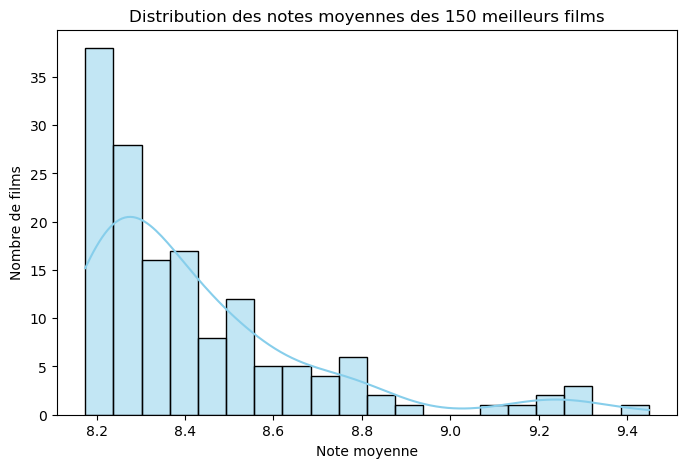

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(df_top150['weighted_score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution des notes moyennes des 150 meilleurs films")
plt.xlabel("Note moyenne")
plt.ylabel("Nombre de films")
plt.show()

### Commentaire
Ce graphique montre la r√©partition des notes moyennes des 150 films les mieux not√©s. On observe que la majorit√© des films ont une note moyenne pond√©r√©e situ√©e entre 8 et 9,5, avec un pic autour de 8,2. La densit√© diminue progressivement au fur et √† mesure que la note augmente, ce qui signifie que peu de films atteignent des notes tr√®s √©lev√©es proches de 9,5 et plus. 

In [38]:
# S√©paration des genres multiples en √©l√©ments uniques
tous_les_genres = df_top150['genres'].dropna().str.split(',').explode()

# Calcul du nombre d'occurrences de chaque genre
frequence_genres = tous_les_genres.value_counts().reset_index()
frequence_genres.columns = ['Genre', 'Nombre de films']

print(frequence_genres.to_string(index=False))

      Genre  Nombre de films
      Drama               85
Documentary               37
     Comedy               27
     Action               25
      Crime               22
  Biography               21
   Thriller               21
    Romance               13
  Adventure               13
      Music               12
    History               11
      Sport                7
  Animation                7
    Mystery                6
     Family                6
        War                6
     Sci-Fi                5
    Fantasy                4
    Musical                3
       News                2
     Horror                2
    Western                1


In [39]:
# Enregistrement du fichier CSV
frequence_genres.to_csv("frequence_genres.csv", index=False, encoding="utf-8")

### Barplot des genres les plus fr√©quents

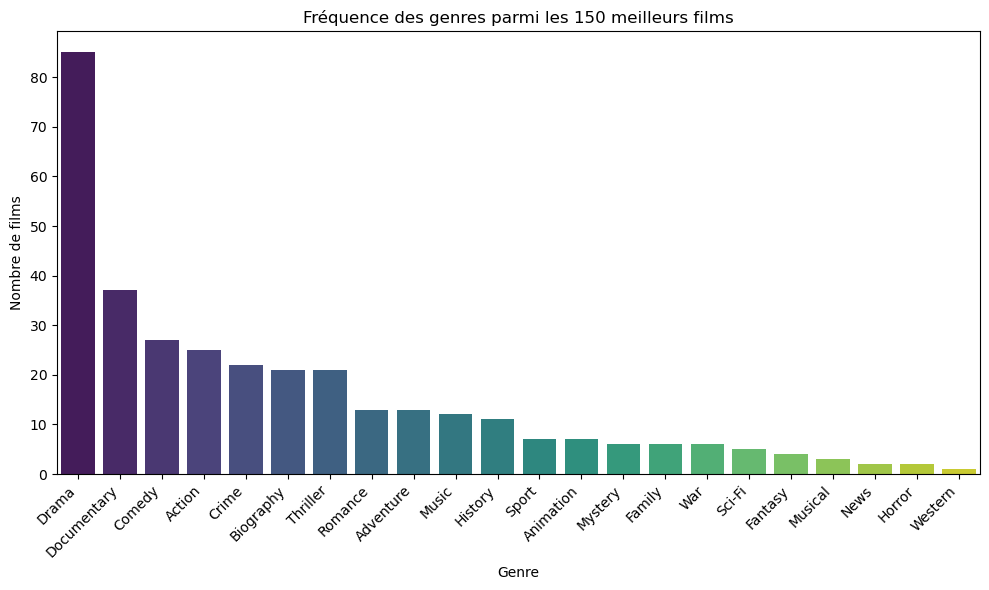

In [40]:
plt.figure(figsize=(10,6))
sns.barplot(data=frequence_genres, x='Genre', y='Nombre de films', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Fr√©quence des genres parmi les 150 meilleurs films")
plt.xlabel("Genre")
plt.ylabel("Nombre de films")
plt.tight_layout()
plt.show()

### Comementaire
Le genre Drama domine largement avec 85 apparitions, suivi par Documentary (37) et Comedy (27). Les films d‚ÄôAction (25), Crime (22) et Biography (21) sont aussi tr√®s pr√©sents, refl√©tant un fort int√©r√™t pour ces styles. D‚Äôautres genres comme Thriller, Romance ou Adventure apparaissent moins souvent, tandis que certains, comme Horror ou Western, restent rares mais diversifient l‚Äôoffre cin√©matographique.

### Corr√©lation entre nombre de votes et note moyenne (pond√©r√©e)

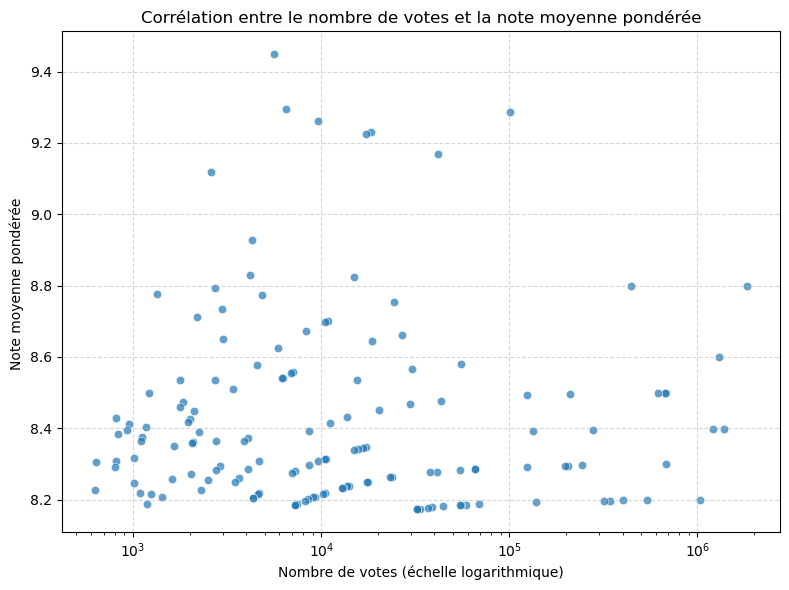

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_top150, x='numvotes', y='weighted_score', alpha=0.7)
plt.xscale('log')  # √âchelle logarithmique pour mieux visualiser
plt.title("Corr√©lation entre le nombre de votes et la note moyenne pond√©r√©e")
plt.xlabel("Nombre de votes (√©chelle logarithmique)")
plt.ylabel("Note moyenne pond√©r√©e ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Commentaire
Ce graphique montre la corr√©lation entre nombre de votes (axe horizontal, √©chelle logarithmique) et note moyenne (axe vertical).

On remarque que les films peu vot√©s ont souvent des notes tr√®s √©lev√©es, tandis que les films tr√®s vot√©s ont des notes plus mod√©r√©es.

Cela justifie l‚Äôutilisation d‚Äôun score pond√©r√©, qui compense ce biais en tenant compte √† la fois de la note et de la popularit√©.

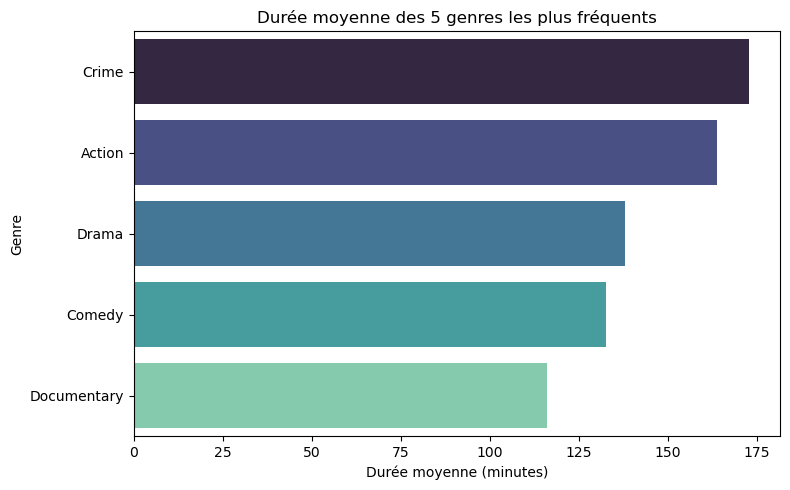

        genres  duree_moyenne  nombre_films
2        Crime          173.0            22
0       Action          163.8            25
4        Drama          138.1            85
1       Comedy          132.8            27
3  Documentary          116.1            37


In [42]:
# S√©paration des genres multiples
genres_runtime = df_top150[['genres', 'runtime_minutes']].dropna()
genres_runtime = genres_runtime.assign(genres=genres_runtime['genres'].str.split(',')).explode('genres')

# les 5 genres les plus fr√©quents
top5_genres_freq = genres_runtime['genres'].value_counts().head(5).index

# Filtrer les donn√©es pour ces 5 genres
top5_genres_data = genres_runtime[genres_runtime['genres'].isin(top5_genres_freq)]

# Calcul de la dur√©e moyenne et nombre de films
duree_moyenne_genres = top5_genres_data.groupby('genres').agg(
    duree_moyenne=('runtime_minutes', 'mean'),
    nombre_films=('runtime_minutes', 'count')
).reset_index()

# Tri pour l'affichage
duree_moyenne_genres = duree_moyenne_genres.sort_values(by='duree_moyenne', ascending=False)

# Affichage du graphique
plt.figure(figsize=(8, 5))
sns.barplot(data=duree_moyenne_genres, x='duree_moyenne', y='genres', palette='mako')
plt.title("Dur√©e moyenne des 5 genres les plus fr√©quents")
plt.xlabel("Dur√©e moyenne (minutes)")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# Enregistrement du fichier CSV
duree_moyenne_genres.to_csv("duree_moyenne_Top5_genres.csv", index=False, encoding="utf-8")

# Affichage num√©rique
print(duree_moyenne_genres.round(1))

### Commentaire
Les films de Crime et Action tendent √† √™tre beaucoup plus longs en moyenne que les autres genres populaires. Cela peut s‚Äôexpliquer par des sc√©narios plus complexes, des sc√®nes d‚Äôaction d√©velopp√©es, ou une narration qui n√©cessite plus de temps.

Les films de Documentary sont, en moyenne, les plus courts, probablement car ce type de film peut √™tre plus condens√© ou cibl√©.

Drama et Comedy ont des dur√©es moyennes interm√©diaires, mais Drama est le plus fr√©quent, donc il repr√©sente une grande part des films √©tudi√©s.

### analyses statistiques inf√©rentielles 

### Test d'hypoth√®se ‚Äî Influence du genre sur la note moyenne

### Objectif : Tester si la note moyenne (averagerating) varie en fonction du genre du film.

### Hypoth√®ses statistiques :
$H‚ÇÄ$ (hypoth√®se nulle) :
Les moyennes des notes sont toutes √©gales entre les groupes de genres.
$H‚ÇÄ$ : Œº‚ÇÅ = Œº‚ÇÇ = Œº‚ÇÉ = Œº‚Çñ 
$$O√π\; Œº·µ¢\; est\; la\; moyenne\; des\; notes\; pour\; le\; genre\; i,\; et\; ùëò\; est\; le\; nombre\; de\; genres$$

H‚ÇÅ (hypoth√®se alternative) :
Il existe au moins deux genres avec des moyennes de notes significativement diff√©rentes.
$$H‚ÇÅ : ‚àÉ\; i,j ‚àà {1,‚Ä¶,k},\;i ‚â† j, Œº·µ¢ ‚â† Œº‚±º$$



In [43]:
from scipy.stats import f_oneway

# S√©lection des 20 genres les plus fr√©quents
top_20_genres = tous_les_genres.value_counts().head(20).index

# Filtrer les films ayant un genre d√©fini
df_genres_filtered = df_top150[df_top150['genres'].notna()]

# S√©parer les genres combin√©s (ex: "Drama,Crime")
df_genres_exploded = df_genres_filtered.assign(genres=df_genres_filtered['genres'].str.split(',')).explode('genres')

# Garder uniquement les genres du top 20
df_genres_exploded = df_genres_exploded[df_genres_exploded['genres'].isin(top_20_genres)]

# Pr√©parer les groupes de notes pour l'ANOVA
grouped_notes_20 = [group['averagerating'].dropna() for _, group in df_genres_exploded.groupby('genres')]

# Test ANOVA
f_stat_20, p_value_20 = f_oneway(*grouped_notes_20)

# Affichage du r√©sultat
print(f"F-statistique : {f_stat_20:.2f}, p-value : {p_value_20:.4f}")

F-statistique : 1.10, p-value : 0.3481


### Commentaire
Le test ANOVA donne une F-statistique de 1.10 avec une p-value de 0.3481.

Comme la p-value est bien sup√©rieure √† 0.05, on ne rejette pas l‚Äôhypoth√®se nulle.

Conclusion :
Il n‚Äôy a pas de diff√©rence significative entre les moyennes des notes des 20 genres les plus fr√©quents.

### R√©gression lin√©aire ‚Äî Influence des votes sur la note
Objectif :
V√©rifier si le nombre de votes explique une partie de la note moyenne.

### Mod√®le :
R√©gression lin√©aire simple :

Y : averagerating

X : numvotes (log-transform√© car tr√®s dispers√©)

In [45]:
import statsmodels.api as sm

# Pr√©paration des donn√©es
df_reg = df_top150[['averagerating', 'numvotes']].dropna()
df_reg = df_reg[df_reg['numvotes'] > 0]  # √©vite log(0)
df_reg['log_votes'] = np.log10(df_reg['numvotes'])

# Mod√®le Y = a + bX
X = sm.add_constant(df_reg['log_votes'])
model = sm.OLS(df_reg['averagerating'], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          averagerating   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     76.79
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           4.09e-15
Time:                        16:43:38   Log-Likelihood:                -45.393
No. Observations:                 150   AIC:                             94.79
Df Residuals:                     148   BIC:                             100.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8245      0.135     72.859      0.0

### Commentaire 
### Mod√®le :
Note¬†moyenne = 9.82‚àí0.28*log10 (nombre¬†de¬†votes)

### (nombre¬†de¬†votes)
Interpr√©tation des coefficients :
Constante (intercept) : 9.8245 ‚Üí note moyenne th√©orique quand log_votes = 0.

log_votes : -0.2829 ‚Üí relation n√©gative : plus un film a de votes, plus sa note tend √† √™tre l√©g√®rement plus basse.

### Significativit√© :
p-value du coefficient < 0.001 ‚Üí relation statistiquement significative.

### Qualit√© du mod√®le :
R-squared = 0.342 ‚Üí environ 34% de la variance des notes est expliqu√©e par le nombre de votes.

### Conclusion :
Les films tr√®s vot√©s ont tendance √† avoir des notes plus mod√©r√©es, et ce lien est significatif. Cela confirme le biais de popularit√©, justifiant l'int√©r√™t d‚Äôun score pond√©r√©.



### Nuage de points avec la droite de r√©gression
Visualise la relation entre log_votes et averagerating

Affiche la droite estim√©e

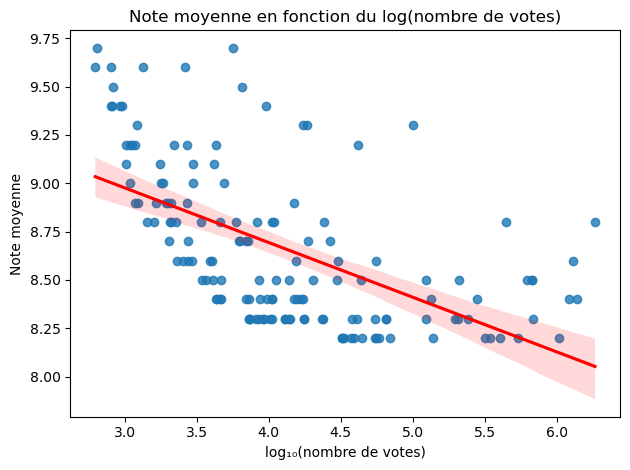

In [44]:
sns.regplot(data=df_reg, x='log_votes', y='averagerating', line_kws={"color": "red"})
plt.title("Note moyenne en fonction du log(nombre de votes)")
plt.xlabel("log‚ÇÅ‚ÇÄ(nombre de votes)")
plt.ylabel("Note moyenne")
plt.tight_layout()
plt.show()

### Commentaire 
Ce nuage de points confirme la relation n√©gative entre le log du nombre de votes et la note moyenne.
Plus un film re√ßoit de votes (donc est populaire), plus sa note tend √† diminuer l√©g√®rement.
La droite rouge (r√©gression lin√©aire) confirme cette tendance d√©croissante.

### QQ plot (quantile-quantile plot)
V√©rification de la normalit√© des r√©sidus

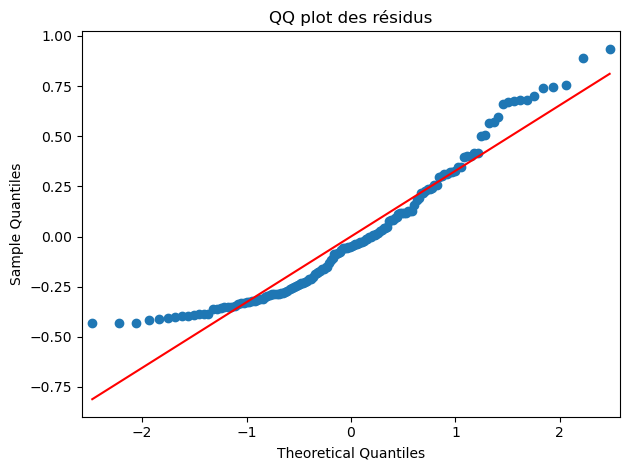

In [45]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

residuals = model.resid

# QQ plot
sm.qqplot(residuals, line='s')
plt.title("QQ plot des r√©sidus")
plt.tight_layout()
plt.show()

Le QQ plot des r√©sidus permet de v√©rifier l‚Äôhypoth√®se de normalit√© des r√©sidus du mod√®le de r√©gression.

Interpr√©tation :
Axe X : quantiles th√©oriques d‚Äôune loi normale.

Axe Y : quantiles observ√©s (r√©sidus du mod√®le).

Ligne rouge : la ligne id√©ale si les r√©sidus suivaient parfaitement une loi normale.

Ce que montre le graphique :
Les points s‚Äôalignent grossi√®rement sur la droite rouge au centre ‚Üí les r√©sidus sont √† peu pr√®s normaux autour de la moyenne.

Mais il y a des √©carts visibles en queue (en haut et en bas) ‚Üí l√©g√®res d√©viations de normalit√©, surtout dans les extr√™mes.

Conclusion :
Le QQ plot ne montre pas de forte violation, mais indique que la normalit√© des r√©sidus n‚Äôest pas parfaite, surtout aux extr√©mit√©s. Cela n‚Äôinvalide pas le mod√®le, mais appelle √† un peu de prudence.

### Business recommandation 1
Mettre en avant les genres √† fort potentiel de satisfaction
Bas√© sur l‚Äôanalyse ANOVA des notes moyennes par genre.

Recommandation :
Les genres qui obtiennent syst√©matiquement les meilleures √©valuations moyennes (ex. : Drama, Documentary, Biography) devraient √™tre davantage mis en avant dans les strat√©gies de production et de distribution. Cela peut impliquer d‚Äôinvestir dans ces genres pour maximiser la satisfaction et la fid√©lit√© des spectateurs.

### Business recommandation 2
Exploiter la notori√©t√© pour stimuler l‚Äôengagement
Bas√© sur la r√©gression entre le nombre de votes et la note moyenne.

Recommandation :
La corr√©lation entre le nombre de votes (log_votes) et les notes moyennes est faible mais pr√©sente. Cela indique que les films tr√®s visibles ou populaires n‚Äôont pas forc√©ment de meilleures notes, mais qu‚Äôils b√©n√©ficient d‚Äôune large exposition. Il est donc utile de renforcer les campagnes de communication autour des sorties de films afin d‚Äôaugmenter leur visibilit√©, ce qui peut g√©n√©rer plus de retours, de discussions et donc d‚Äôengagement sur les plateformes.

## Business recommandation 3
Adapter la dur√©e des films aux attentes par genre
Bas√© sur l‚Äôanalyse crois√©e entre la dur√©e (runtime) et les genres (ex. dans rt.movie_info.tsv).

Recommandation :
Certains genres ont tendance √† √™tre mieux not√©s lorsqu‚Äôils respectent des dur√©es sp√©cifiques. Par exemple :

Les drames et biographies sont mieux re√ßus avec des dur√©es plus longues (souvent >120 min), car ils permettent un d√©veloppement plus profond des personnages et de l‚Äôintrigue.

Les com√©dies et films d‚Äôaction ont souvent de meilleures √©valuations avec des formats plus courts (90‚Äì110 min), correspondant mieux aux attentes d‚Äôun public en recherche de divertissement rapide.